In [31]:
from pylab import *
#from netCDF4 import *
from dwell import fft
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.signal import freqz
from scipy.signal import butter, lfilter
from tqdm import tqdm
import matplotlib.colors as colors
from matplotlib.colors import SymLogNorm


def martians_year(ls, data):
    #### only looking at "second year"
    idx = np.where(ls==360)[0]
    if idx[0] != 0 and idx.size > 1:
        idx0 = idx[0]
        idx1 = idx[1]
        return data[idx0:idx1]
    elif idx[0] != 0 and idx.size == 1:
        idx1 = idx[0]
        return data[:idx1]
    elif idx[0] == 0:
        idx1 = idx[1]
        idx2 = idx[2]
        return data[idx1:idx2]

def martians_month(ls, data):
    temp = []
    for i in np.arange(0, 12):
        idx = np.where((ls>i*30)&(ls<(i+1)*30))[0]
        temp.append(data[idx].mean(axis=0))
    temp = np.array(temp)
    return temp

def zonal_plt_monthly(ydata, ls, data, title, level, norm, cmap):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,14))
    for i, ax in enumerate(axes.flat):
        y = ydata[i]
        
        #press2 = zonal_p[i-1].mean(axis=1)
        lat = np.linspace(-90, 90, 36) 
        temp_press = np.linspace(900, 1e-2, y.shape[0])[:]
        
        lat, temp_press = np.meshgrid(lat, temp_press)
        
        d = data[i]
        
        norm = colors.Normalize(vmin=-1, vmax=1)
        
        im = ax.contourf(lat, y, d, cmap=cmap, levels=level, norm=SymLogNorm(linthresh=1e5,vmin=np.min(d), vmax=np.max(d)))
        if not np.isnan(d).any():
            ax.contour(lat, y, d, linewidths=0.5, colors='k', levels=level, norm=SymLogNorm(linthresh=1e5,vmin=np.min(d), vmax=np.max(d)))
        
        ax.set_title(r'{} LS {}-{}'.format((title), (i)*30, (i+1)*30))
        if i in [0,4,8]: ax.set_ylabel('Pressure [Pa]')
        if i in [8,9,10,11]: ax.set_xlabel('Latitude [$^\circ$]')
        ax.set_yscale('log')
        ax.set_ylim([900, 1e-1])
        
        ax.xaxis.set_minor_locator(AutoMinorLocator(4))
        
    fig.tight_layout()
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3, orientation='horizontal', pad=0.04)
    plt.savefig('r14p1.pdf', format='pdf', bbox_inches='tight', dpi=400)
    plt.show()


from matplotlib.ticker import AutoMinorLocator
matplotlib.rcParams.update({'font.size': 10})

matplotlib.rcParams['lines.linewidth'] = 0.5

matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1.5

matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 1.5

In [32]:
import scipy.interpolate as interpolate

filedir = "./../fullfield/r14p1/"

filepath = glob.glob(filedir + '*_TPOT.npy')[0]
T = np.load(filepath)

filepath = glob.glob(filedir + '*_P.npy')[0]
P = np.load(filepath)

filepath = glob.glob(filedir + '*_VFULL.npy')[0]
V = np.load(filepath)

filepath = glob.glob(filedir + '*_LS.npy')[0]
ls = np.load(filepath)

T = martians_year(ls, T)
P = martians_year(ls, P)
V = martians_year(ls, V)
ls = martians_year(ls, ls)

V = 1/2.*(V[:,:,1:]+V[:,:,:-1])

print (T.shape, P.shape, V.shape)

Tmean = T.mean(axis=3).mean(axis=0)
Vmean = V.mean(axis=3).mean(axis=0)
Tprimed = T - Tmean[np.newaxis, :, :, np.newaxis]
Vprimed = V - Vmean[np.newaxis, :, :, np.newaxis]

tmp = (Tprimed*Vprimed).mean(axis=3)
t = T.mean(axis=3)
del Tprimed, Vprimed
print (tmp.shape)

P = P[:,:]
t = t[:,:]
tmp = tmp[:,:]

#del V, T
#np.save('tmp.npy', tmp)
#del V

(5352, 52, 36, 72) (5352, 52, 36) (5352, 52, 36, 72)
(5352, 52, 36)


In [33]:
from scipy.interpolate import splprep, splev, interp1d

new_pressure = P[10,:,:]#np.linspace(900,1e-2,52)
print (new_pressure.shape)

dtdp = zeros_like(t)
dndp = zeros_like(t)
print('Calculating residual mean circulation ...')
for i in tqdm(np.arange(tmp.shape[0])):
    for j in np.arange(tmp.shape[2]):
        tst = interpolate.UnivariateSpline(P[i,::-1,j], t[i,::-1,j], k=3, s=0)
        
        #tck, u = splprep([P[i,::-1,j], t[i,::-1,j]], k=2, s=0)
        #dp, dt = splev(u, tck, der=1)
        #dtdp[i,::-1,j] = 1e-14+dt/dp
        #if i%233 == 0: print (dtdp[i,::-1,j])
        dtdp[i,::-1,j] = tst(P[i,::-1, j], 1)
        #test = interpolate.UnivariateSpline(P[i,::-1,j], dtdp[i,::-1,j],k=2, s=10)
        #dtdp[i,::-1,j] = test(P[i,::-1,j])
        
#np.where(abs(dtdp)>1e-2, dtdp, nan)

dtdp = ma.array(dtdp,mask=abs(1./dtdp)>1.5e2)
tmp2 = tmp/dtdp

for i in tqdm(np.arange(tmp.shape[0])):
    for j in np.arange(tmp.shape[2]):
        #tmp2 = tmp[i,::-1,j]/dtdp[i,::-1,j]
        #tck, u = splprep([P[i,::-1,j], tmp2], k=2, s=0)
        #dp, dn = splev(u, tck, der=1)
        #dndp[i,::-1,j] = dn/dp 
        tst2 = interpolate.UnivariateSpline(P[i,::-1,j], tmp2[i,::-1,j], k=3,s=0)
        dndp[i,::-1,j] = tst2(P[i,::-1, j], 1)


(52, 36)
Calculating residual mean circulation ...


100%|█████████████████████████████████████████████████████████████████████████████| 5352/5352 [00:09<00:00, 587.18it/s]


In [34]:
import scipy.integrate as integrate

v = V.mean(axis=3)
v = v[:,:]
v_starprimed = v - dndp

lat = np.linspace(-90,90,36)
a = 3389920.
g = 3.727
tmp3 = np.zeros_like(v_starprimed)
for i in tqdm(np.arange(tmp3.shape[0])):
    for j in np.arange(tmp3.shape[2]):
        tmp3[i,::-1,j] = 2*np.pi*(a/g)*np.cos(np.deg2rad(lat[j]))*integrate.cumtrapz(v_starprimed[i,::-1,j], P[i,::-1, j], initial=0)
        

100%|█████████████████████████████████████████████████████████████████████████████| 5352/5352 [00:05<00:00, 991.97it/s]


(52, 36)


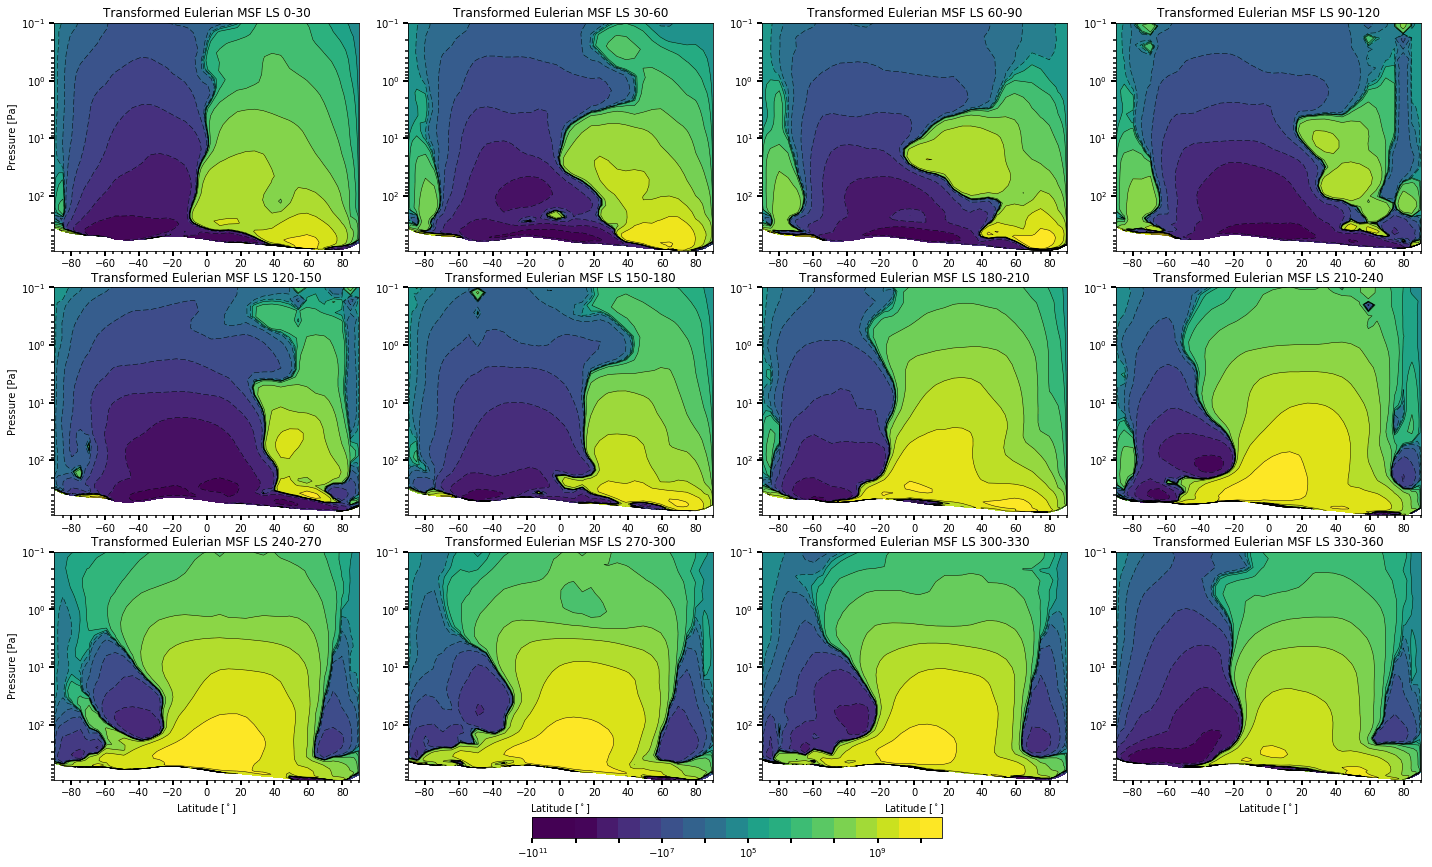

In [35]:
def mklev(d,pl,ph,n):
    l,h=np.percentile(d,[pl,ph])
    return np.linspace(l,h,n)

slev = np.logspace(5,11,10)
slev = np.hstack([-1*slev[::-1],slev])

import matplotlib.colors as mc

norm = mc.BoundaryNorm(slev,250)

print(new_pressure.shape)

final = martians_month(ls, tmp3)
zonal_p = martians_month(ls, P)
zonal_plt_monthly(zonal_p, ls, final, 'Transformed Eulerian MSF', slev, norm, 'viridis')#np.linspace(-1e10,2e10,14)


final = martians_month(ls, dtdp)
#zonal_plt_monthly(zonal_p, ls, final, 'Transformed Eulerian MSF', mklev(final,1,99,11), 'viridis') #np.linspace(-1e10,2e10,14)

dtdp= ma.array(dtdp,mask=abs(1./dtdp)>1e3)

final2 = martians_month(ls, dtdp)
#zonal_plt_monthly(zonal_p, ls, final2, 'Transformed Eulerian MSF', mklev(final2,1,99,11), 'viridis') #np.linspace(-1e10,2e10,14)

#final = martians_month(ls, dtdp)
#zonal_plt_monthly(zonal_p, ls, final, 'Transformed Eulerian MSF', np.linspace(-1,0.2,15), 'viridis') #np.linspace(-1e10,2e10,14)

In [374]:
w=where(abs(ls-135)<15)
print(dtdp.shape)
print(t[w[0][94],10:20,29])

(5352, 52, 36)
[-68.93867493 -68.81291962 -68.75816345 -68.74832916 -68.76118469
 -68.86331177 -68.86309052 -68.83300781 -68.62703705 -67.77498627]


In [363]:
a = np.arange(10)
b = ma.array(a, mask=1./a>5)
print (b)

C:\Users\visal\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


[-- 1 2 3 4 5 6 7 8 9]
